### Import neccesary libraries


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

plt.style.use("default") 

### Define the split type and stock name


In [34]:
split_type = [0.8,0.7,0.9]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [35]:
split = 1
stock = 0 # FPT

## 1.Data preprocessing


In [36]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,19240,19270,19080,19270,590780,FPT
1,2019-03-04,19270,19520,19270,19440,806770,FPT
2,2019-03-05,19440,19520,19350,19390,824300,FPT
3,2019-03-06,19410,19480,19210,19270,695230,FPT
4,2019-03-07,19270,19440,19270,19330,374340,FPT
...,...,...,...,...,...,...,...
1308,2024-05-27,133000,133500,130600,132800,5157800,FPT
1309,2024-05-28,134000,137000,133100,137000,4625300,FPT
1310,2024-05-29,137100,138200,134800,135700,5837600,FPT
1311,2024-05-30,133800,135000,131900,135000,7261300,FPT


<Axes: >

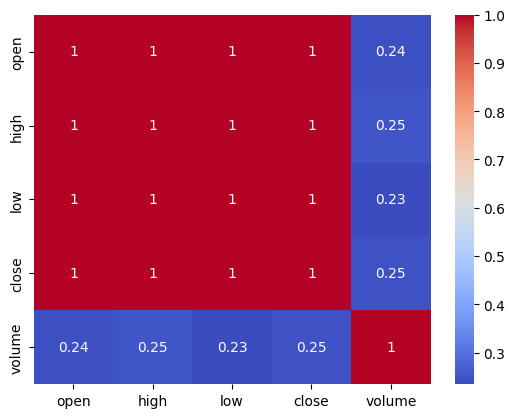

In [37]:
# Create a correlation matrix
df1 = df.drop(columns=["time", "ticker"], axis=1)
corr_matrix = df1.corr()

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#### Low price and close price are correlated => Good for forecast the "close price" in SARIMAX model

In [38]:
df = df[["low", "close"]] # Using low and close price to predict the next day close price, the low price is the exogenous variable

df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


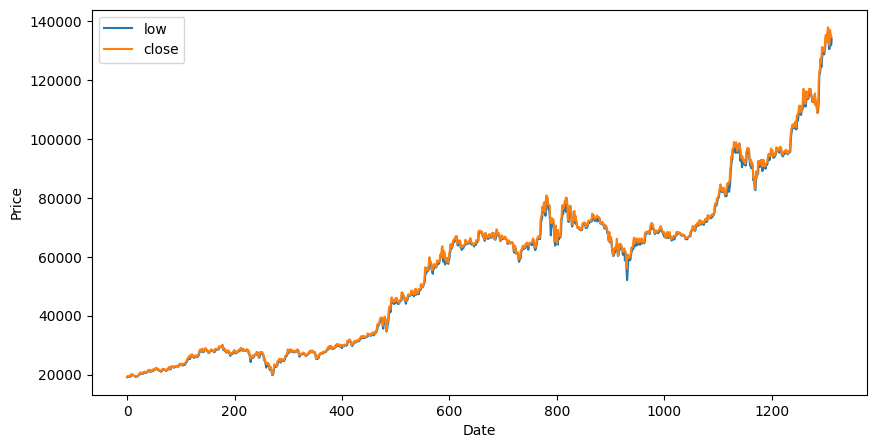

In [39]:
df.plot(figsize=(10, 5))
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

In [40]:
df.reset_index(drop=True)
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


In [41]:
# Shape of the dataframe
df.shape

(1313, 2)

In [42]:
df.dtypes

low      int64
close    int64
dtype: object

In [43]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,56251.291698,56880.086824
std,27151.082839,27473.981127
min,19080.000000,19190.000000
25%,28120.000000,28410.000000
50%,62770.000000,63470.000000
75%,70940.000000,71450.000000
max,136100.000000,138000.000000


## 2. Train model


In [44]:
# Defining the split size
train_size = int(split_type[split] * len(df))
test_size = len(df) - train_size

In [45]:
# splitting data into train, test set
train_data = df[:train_size]
test_data = df[train_size:]

In [46]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

In [47]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(1.8386035496403492,
 0.9984225848793727,
 21,
 1291,
 {'1%': -3.4354254066484664,
  '5%': -2.863781366113082,
  '10%': -2.56796331977745},
 21624.1407585791)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [48]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [49]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.895
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.908
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


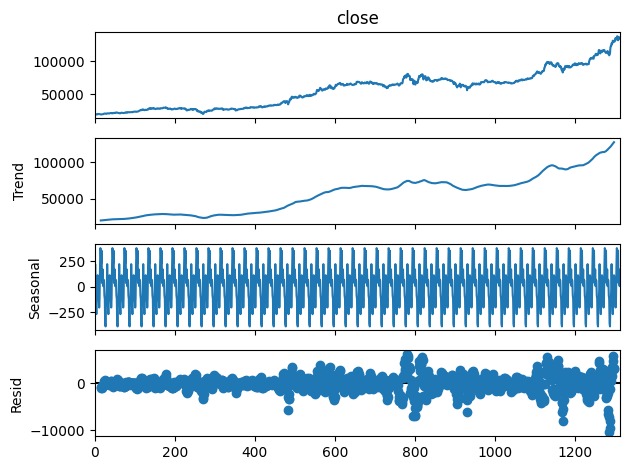

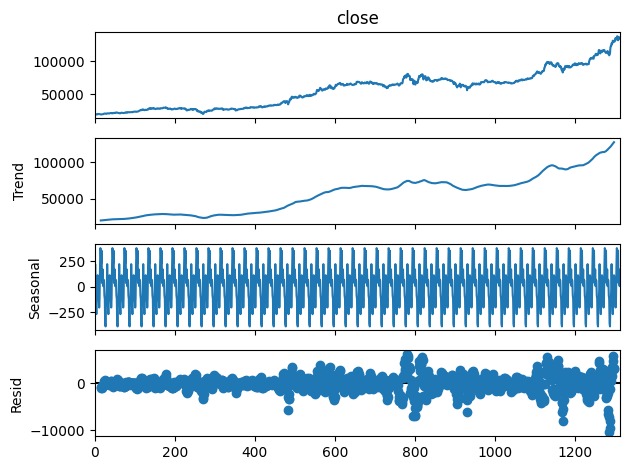

In [50]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [51]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [52]:
# Check again
adfuller(df_diff)

(-7.510879219513474,
 4.018716448015234e-11,
 20,
 897,
 {'1%': -3.4376611618861697,
  '5%': -2.864767502722044,
  '10%': -2.5684885413039127},
 14768.28656282628)

The p-value is less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

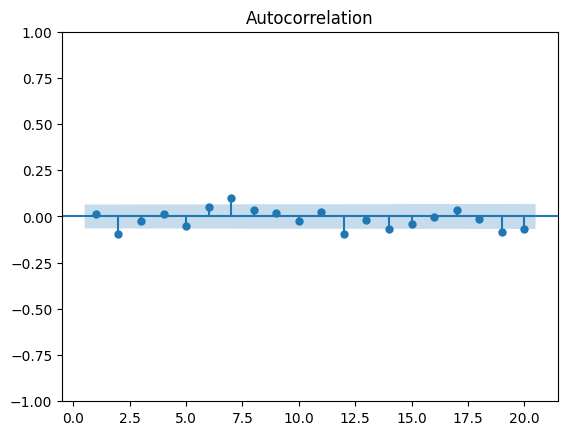

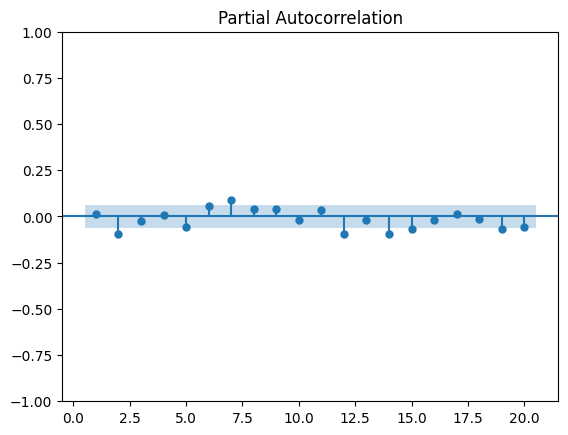

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [54]:
# Review the dataset again
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


In [55]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=15130.942, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=15132.337, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=15132.147, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=15131.503, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=15130.585, Time=0.12 sec
 ARIMA(0,1,0)(2,0,0)[5] intercept   : AIC=15131.864, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=15131.529, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=15130.436, Time=0.04 sec
 ARIMA(0,1,0)(0,0,2)[5] intercept   : AIC=15131.437, Time=0.07 sec
 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=15132.595, Time=0.45 sec
 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=15132.180, Time=0.15 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=15132.826, Time=0.34 sec
 ARIMA(0,1,0)(0,0,1)[5]             : AIC=15131.473, Time=0.02 sec

Best model:  ARIMA(0,1,0

In [56]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  919
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood               -7562.218
Date:                             Thu, 20 Jun 2024   AIC                          15130.436
Time:                                     07:03:49   BIC                          15144.903
Sample:                                          0   HQIC                         15135.957
                                             - 919                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     48.4205     29.349      1.650      0.099      -9.102     105.943
ma.S.L5       -0.0517      

#### Use SARIMAX to train model


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(0, 1, 0),
    seasonal_order=(0, 0, 1, 5),
)

model_fit = model1.fit()

### Test


In [58]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([ 63318.68313191,  63809.9574939 ,  63357.76844834,  63135.15233239,
        62195.74508757,  62705.0478397 ,  62146.45772446,  63033.63026043,
        61078.56485708,  62425.75278208,  61494.76925668,  59594.46759012,
        57447.72910802,  58937.30274866,  61122.37584652,  61264.76156216,
        61078.56485708,  61357.8599147 ,  61215.47419906,  61730.25332487,
        62568.13849773,  62891.24454478,  63126.72861297,  63400.54729691,
        63356.73630748,  64939.40830066,  64287.17219551,  63734.60609132,
        64101.5231278 ,  64380.27054805,  64473.91653796,  63915.32642272,
        64331.53082231,  64473.91653796,  64473.91653796,  64567.0148905 ,
        64008.42477526,  64150.26285354,  64287.17219551,  64380.27054805,
        64473.91653796,  64287.17219551,  64287.17219551,  64380.27054805,
        64287.17219551,  64660.11324304,  65821.10446295,  66242.78523622,
        66242.78523622,  66105.87589425,  66242.78523622,  66335.88358876,
        66242.78523622,  

### Forecast the next 30/60/90 days


In [59]:
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [60]:
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


In [61]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Forecast closing prices for the next 30 days:")
print(y_30_days_pred)

Forecast closing prices for the next 30 days:
[85090.64625292 85017.06345695 85067.91012081 85019.74729354
 85141.96587338 85179.50982009 85217.05376681 85254.59771352
 85292.14166024 85329.68560695 85367.22955367 85404.77350038
 85442.3174471  85479.86139381 85517.40534053 85554.94928724
 85592.49323396 85630.03718067 85667.58112739 85705.1250741
 85742.66902082 85780.21296753 85817.75691425 85855.30086096
 85892.84480768 85930.38875439 85967.93270111 86005.47664782
 86043.02059454 86080.56454125]


### Plotting the data


In [62]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Next {days} days", linestyle="--"
    )
    plt.title(f"Forecast {stock_name[stock]} Stock Price Using SARIMAX")
    plt.legend()
    plt.show()

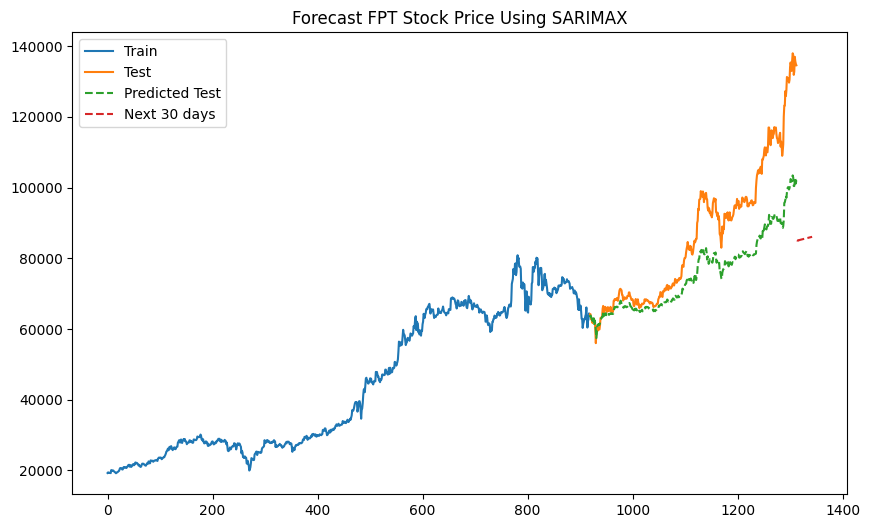

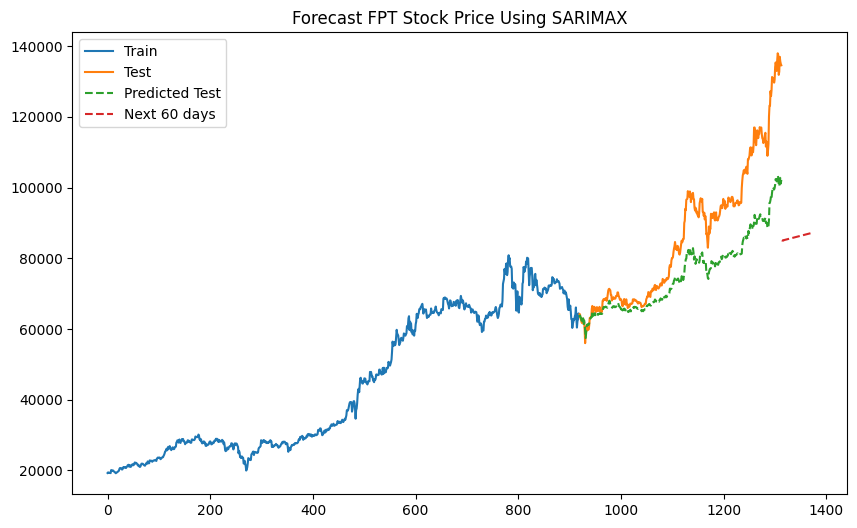

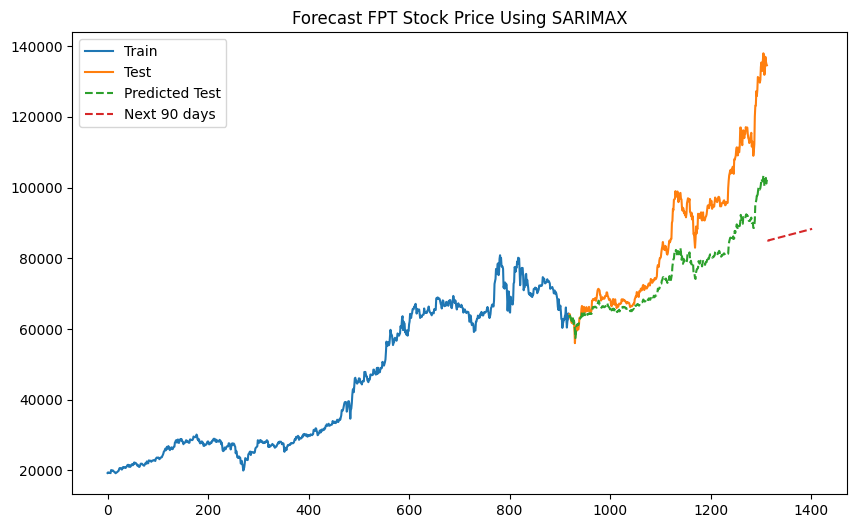

In [63]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [64]:
# Model evaluation on test set
print(f"RMSE: {rmse(y_test, y_pred_test)}")
print(f"MAE: {mae(y_test, y_pred_test)}")
print(f"MAPE: {mape(y_test, y_pred_test) * 100} %")

RMSE: 13980.543014048966
MAE: 10637.005491613012
MAPE: 10.691444841037402 %
